In [1]:

import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from swimnetworks import Dense, Linear

from dataset.dataset import Dataset
from models.base_model import BaseModel
from models.neural_net import NeuralNet
from models.sampled_net import SampledNet
from view.visualizer import plot_weight_biases_differences, model_base_vs_model_sampled, \
    plot_weight_vectors_and_point_pairs


In [2]:


xd = 2  # Input space dimensions
yd = 4  # Output dimension
num_samples = 50  # Number of data points
layer_width = 20

dataset = Dataset()
dataset.create_dataset_sinus_2d(num_samples)
dataset.scale(preprocessing.MinMaxScaler(feature_range=(0, 2)))
dataset.split_train_test(0.2)

### Train network with swim

In [3]:

steps = [
    (
        "dense",
        Dense(
            layer_width=layer_width,
            activation="relu",
            parameter_sampler="relu",
            random_seed=42,
        ),
    ),
    ("linear", Linear(regularization_scale=1e-10)),
]
model_swim = Pipeline(steps)

model_swim.fit(dataset.X_train, dataset.y_train)

model_base_swim = BaseModel()

model_base_swim.weights = [
    model_swim.get_params()["steps"][0][1].weights,
    model_swim.get_params()["steps"][1][1].weights,
]
model_base_swim.biases = [
    -model_swim.get_params()["steps"][0][1].biases[0],
    -model_swim.get_params()["steps"][1][1].biases[0],
]

y_predict = model_base_swim.predict(dataset.X_test)
y_swim = model_swim.predict(dataset.X_test)

print(f"Predictions from 'model_base' and 'model_swim' are equal: {np.array_equal(y_predict, y_swim)}")

Predictions from 'model_base' and 'model_swim' are equal: True


### train network with Adam

In [4]:
model_adam = NeuralNet()
model_adam.fit(dataset.X_train, dataset.y_train, [layer_width], epochs=10)


### Fit SampledNet with the model_base, and visualization of the weight angles and bias differences of the first layer, and weight vs x_1, x_2 (same direction if model_base is trained with Swim)

Layer1 sampling: 100%|██████████| 20/20 [00:00<?, ?it/s]


train: loss(y_base_model, y_sampled)
r2: 1.0	mse: 2.004199737327133e-30
test: loss(y_base_model, y_sampled)
r2: 1.0	mse: 1.8661490789134558e-30
are given weight matrices equal:  False


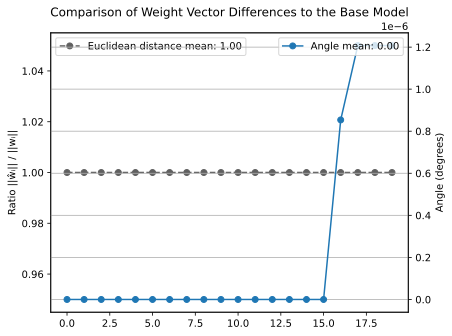

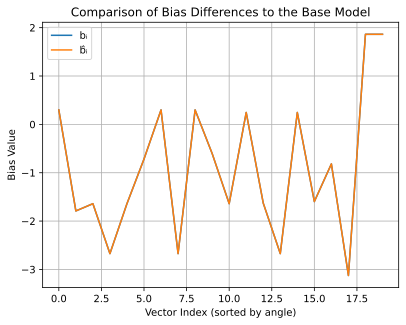

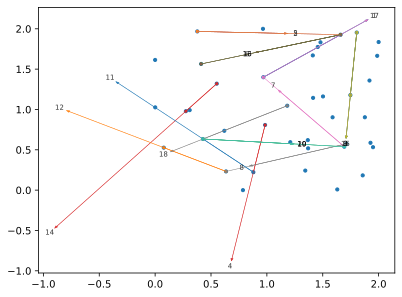

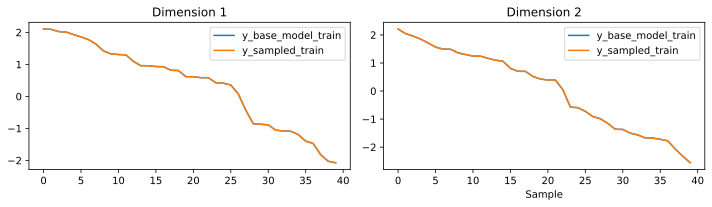

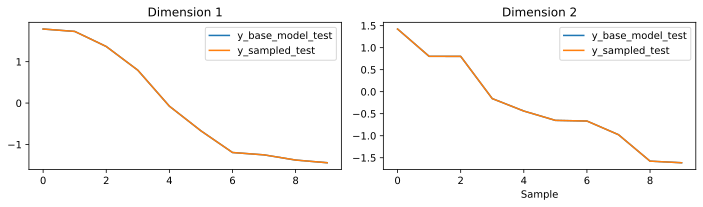

In [5]:
model_base = model_base_swim

y_nn_train = model_base.predict(dataset.X_train)

model_sampled = SampledNet()
x_1_x2_tuples = model_sampled.fit(dataset.X_train, y_nn_train, model_base, layer2="classic", radius=0.05,
                                  project_onto_boundary=False)
model_base_vs_model_sampled(dataset, model_base, model_sampled, x_1_x2_tuples)


### visualize the num_vectors_to_visualize weight and (x_1,x_2) vectors during training of a network with adam. sorted by weight norm.

Validation Loss after 20 epochs: 0.4866


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 208.28it/s]


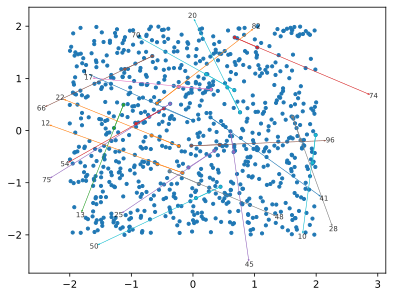

are given weight matrices equal:  False


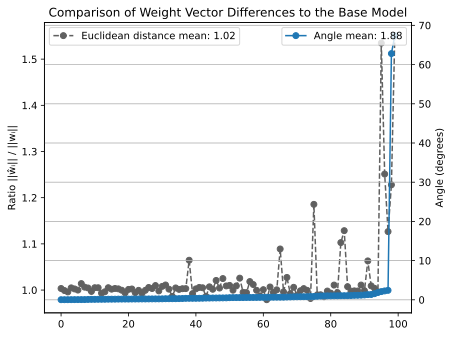

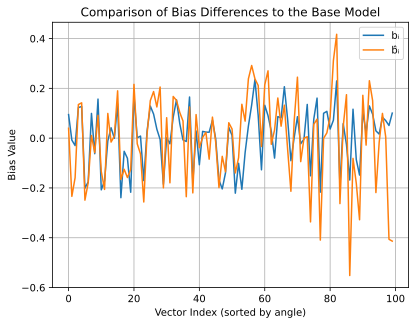

Validation Loss after 40 epochs: 0.2221


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 210.01it/s]


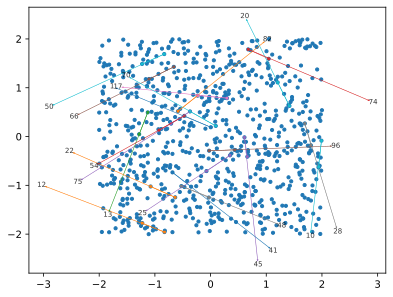

are given weight matrices equal:  False


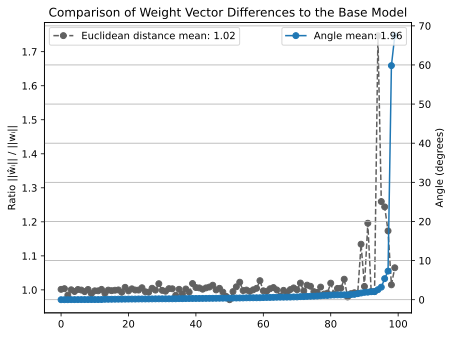

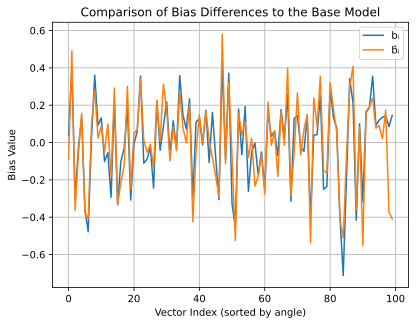

Validation Loss after 60 epochs: 0.1232


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 215.69it/s]


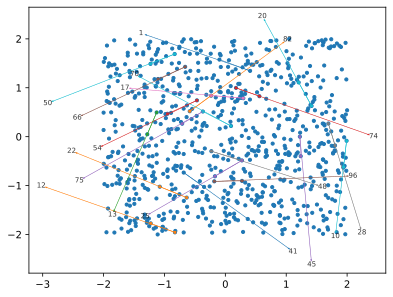

are given weight matrices equal:  False


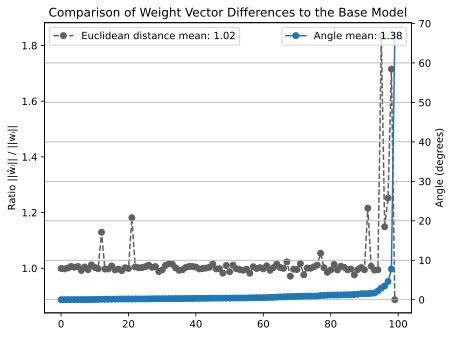

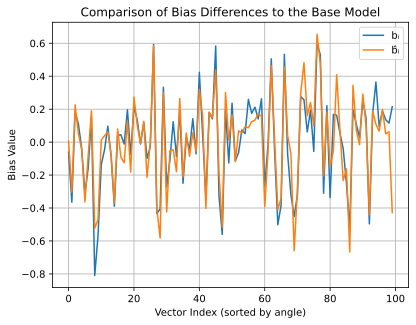

Validation Loss after 80 epochs: 0.0709


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 218.47it/s]


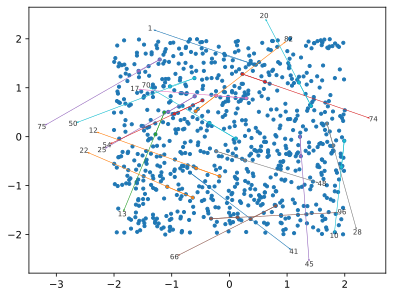

are given weight matrices equal:  False


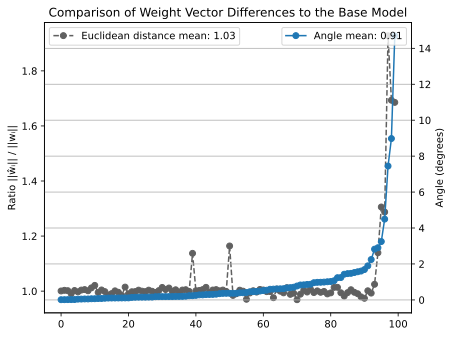

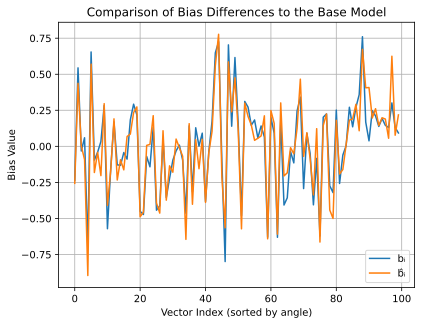

Validation Loss after 100 epochs: 0.0464


Layer1 sampling: 100%|██████████| 100/100 [00:00<00:00, 210.97it/s]


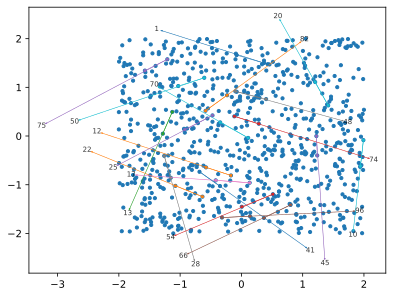

are given weight matrices equal:  False


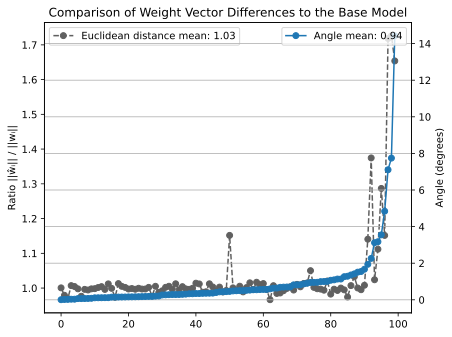

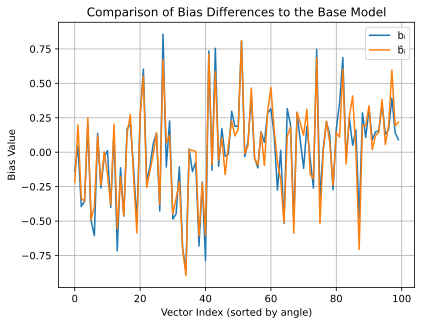

In [6]:


xd = 2  # Input space dimensions
num_samples = 1000  # Number of data points
layer_width = 100

d_epochs = 20
num_intervals = 5

num_vectors_to_visualize = 20

dataset = Dataset().create_dataset_sinus_2d(num_samples)
dataset.scale(preprocessing.MinMaxScaler(feature_range=(-2, 2)))
dataset.split_train_test(0.2)

model = NeuralNet()

initial_epoch = 0

for i in range(num_intervals):
    if i == 0:
        model.fit(dataset.X_train, dataset.y_train, layers=[layer_width], epochs=d_epochs, validation_split=0.3)
    else:
        model.resume_training(
            dataset.X_train,
            dataset.y_train,
            initial_epoch=initial_epoch,
            epochs=initial_epoch + d_epochs,
            validation_split=0.3,
        )

    # Evaluate the model after training
    x = model.model.evaluate(dataset.X_test, dataset.y_test, verbose=0)

    print(f"Validation Loss after {initial_epoch + d_epochs} epochs: {x:.4f}")

    model_sampled = SampledNet()
    x_1_x2_tuples = model_sampled.fit(dataset.X_train, dataset.y, model, radius=0.05)

    plot_weight_vectors_and_point_pairs(
        dataset.X_train, x_1_x2_tuples, np.transpose(model.weights[0]), num_vectors=num_vectors_to_visualize
    )
    plot_weight_biases_differences(model.weights[0], model_sampled.weights[0], model.biases[0], model_sampled.biases[0])

    initial_epoch += d_epochs
